# A tutorial on gradient damage as phase-field models of brittle fracture
* Author: Corrado Maurini, 2017, corrado.maurini@upmc.fr
* This file is distributed as support to the class *5AG08 - Endommagement et Rupture* of the Master MSGC/MS2 of UPMC

In this notebook we implement a numerical solution of the quasi-static evolution problem for gradient damage models, and show how they can be used to solve brittle fracture problems.

Denoting by $u$ the displacement field (vector valued) and by $\alpha$ the scalar damage field we consider the energy functional

$$
		\mathcal{E}_{\ell}(u, \alpha)=
		\dfrac{1}{2}\int_{\Omega} a({\alpha})
		A_0\,\epsilon(u)\cdot\epsilon(u)\,dx
		+
         \,
		\dfrac{G_c}{c_w} \int_{\Omega}\left(
		\dfrac{w(\alpha)}{\ell}+
		{\ell}\,\nabla {\alpha}\cdot\nabla{\alpha}\right)dx
$$

where $\epsilon(u)$ is the strain tensor, $\sigma_0(u)=A_0\,\epsilon(u)$ the stress of the undamaged material, $a({\alpha})$  the stiffness modulation function though the damage field, $w_1\,w(\alpha)$ the energy dissipation in an homogeouns process and $\ell$ the internal length.

In the following we will solve, at each time step $t_i$ the minimization problem 

$$
\min\mathcal{E}_{\ell}(u, \alpha),\quad u\in\mathcal{C}_i, \alpha\in \mathcal{D}_i
$$

where $\mathcal{C}_i$ is the space of kinematically admissible displacement at 
time $t_i$ and $\mathcal{D}_i$ the admissible damage fields, that should respect the irreversibility conditions 
$\alpha\geq\alpha_{i-1}$. 

Here we will
 * Discretize the problme using $P_1$ finite elements for the displacement and the damage field
 * Use alternate minimization to solve the minimization problem at each time step
 * Use FEniCS/PETSc/TAO solver to solve linear problems and variational inequality at discrete level

The code depends on FEniCS 2017.1.0. To run it we suggest to follow one of the following solutions:
 - Use Azure Notebooks
 - Use Docker containers provided by FEniCS developers, see here: https://fenicsproject.org/download/
 
*Note: This Notebook includes the full code to solve the problem. We suggest to skip the reading of the sections marked with the label
**(skip)**
in a first reading of the notebook. These parts contains purely technical details that are not interesting to understanding the core of the program. You can evanluate them without trying to understand the content in a first step.

We will consider here the specific problem of the **traction of a two-dimensional bar in plane-stress**, where
$
\Omega =[0,L]\times[0,H]
$ and the loading is given by 
under imposed end-displacement $u=(t,0)$ in $x=L$, the left-end being clamped : $u=(0,0)$ in $x=0$. You can solve more coplex problem by simply twicking of this file.

You can find further informations about this model here:
- Marigo, J.-J., Maurini, C., & Pham, K. (2016). An overview of the modelling of fracture by gradient damage models. Meccanica, 1–22. https://doi.org/10.1007/s11012-016-0538-4 

# Preamble (skip)

You can safely skip reading this section at first reading. Here we import the required python modules and set few parameters.

In [1]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np
import sys, os, sympy, shutil, math
parameters.plotting_backend = "matplotlib"
%matplotlib inline
parameters.form_compiler.update({"optimize": True, "cpp_optimize": True, 
                                 "representation":"quadrature", "quadrature_degree": 2})

# Mesh 

We define here the mesh and the indicators for the boundary conditions. We used `mshr`, the meshing utility provided by FEniCS: https://bitbucket.org/fenics-project/mshr

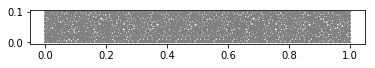

In [2]:
L = 1.; H = 0.1;
cell_size = 0.02;
nel = int(L/cell_size)
geom = Rectangle(Point(0., 0.), Point(L, H))
mesh = generate_mesh(geom,nel)
ndim = mesh.topology().dim() # get number of space dimensions
plot(mesh)

### Boundary indicators  (skip) 
We define below boundary indicators to impose boundary conditions and add the corresponding tags to the boundaries.

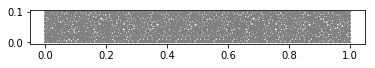

In [3]:
left = CompiledSubDomain("near(x[0], 0, 1e-4)")
right = CompiledSubDomain("near(x[0], %s, 1e-4)"%L)
boundaries = FacetFunction("size_t", mesh)
boundaries.set_all(0)
left.mark(boundaries, 1) # mark left as 1
right.mark(boundaries, 2) # mark right as 2
ds = Measure("ds",subdomain_data=boundaries) # left: ds(1), right: ds(2)
plot(mesh)

# Variational formulation of the problem

## Constitutive functions

We define here the constitutive functions and the related parameters. 
These functions will be used to define the energy. You can try to change them, the code is sufficiently generic to allows for a wide class of function $w$ and $a$.

**Exercice:** Show by dimensional analysis that varying $G_c$ and $E$ is equivalent to a rescaling of the displacement by a factor 

$$
u_0 = \sqrt{\frac{G_c L}{E}}
$$

We can then choose these constants freely in the numerical work and simply rescale the displacement to match the material data of a specific brittle material. 
The *real* material parameters (in the sense that they are those that affect the results) are   
- the Poisson ratio $\nu$ and 
- the ratio $\ell/L$ between internal length $\ell$ and the domain size $L$. 

In [4]:
E, nu = Constant(100.0), Constant(0.3)
Gc = Constant(1.0)
ell = Constant(0.05)

def w(alpha):
    """Dissipated energy function as a function of the damage """
    return alpha

def a(alpha):
    """Stiffness modulation as a function of the damage """
    k_ell = Constant(1.e-6) # residual stiffness
    return (1-alpha)**2+k_ell

def eps(u):
    """Strain tensor as a function of the displacement"""
    return sym(grad(u))

def sigma_0(u):
    """Stress tensor of the undamaged material as a function of the displacement"""
    mu    = E/(2.0*(1.0 + nu))
    lmbda = E*nu/(1.0 - nu**2)
    return 2.0*mu*(eps(u)) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(u,alpha):
    """Stress tensor of the damaged material as a function of the displacement and the damage"""
    return (a(alpha))*sigma_0(u)


**Exercise:** Show that 
1. One can relate the dissipation constant $w_1$ to the energy dissipated in a smeared representation of a crack through the following relation:
\begin{equation}
{G_c}={c_w}\,w_1\ell,\qquad c_w =4\int_0^1\sqrt{w(\alpha)}d\alpha
\end{equation}
2. The half-width of a localisation zone is given by:
$$
D =  c_{1/w} \ell,\qquad c_{1/w}=\int_0^1 \frac{1}{\sqrt{w(\alpha)}}d\alpha
$$
3. The elastic limit of the material is:
$$
\sigma_c = \sqrt{w_1\,E_0}\sqrt{\dfrac{2w'(0)}{s'(0)}}= \sqrt{\dfrac{G_cE_0}{\ell c_w}}
\sqrt{\dfrac{2w'(0)}{s'(0)}}
$$
*Hint:* Calculate the damage profile and the energy of a localised solution with vanishing stress in a 1d traction problem

For the function above we get (we perform the integral with `sympy`).

In [5]:
z = sympy.Symbol("z")
c_w = 4*sympy.integrate(sympy.sqrt(w(z)),(z,0,1))
print("c_w = ",c_w)
c_1w = sympy.integrate(sympy.sqrt(1/w(z)),(z,0,1))
print("c_1/w = ",c_1w)
tmp = 2*(sympy.diff(w(z),z)/sympy.diff(1/a(z),z)).subs({"z":0})
sigma_c = sympy.sqrt(tmp*Gc*E/(c_w*ell))
print("sigma_c = %2.3f"%sigma_c)
eps_c = float(sigma_c/E)
print("eps_c = %2.3f"%eps_c)

c_w =  8/3
c_1/w =  2
sigma_c = 27.386
eps_c = 0.274


## Finite element function space

We use $P_1$ finite element (triangle with linear Lagrange polynomial as shape functions and nodal values as dofs) for both displacement and damage. 

In [6]:
# Create function space for 2D elasticity + Damage
V_u = VectorFunctionSpace(mesh, "P", 1)
V_alpha = FunctionSpace(mesh, "P", 1)

# Define the function, test and trial fields
u, du, v = Function(V_u), TrialFunction(V_u), TestFunction(V_u)
alpha, dalpha, beta = Function(V_alpha), TrialFunction(V_alpha), TestFunction(V_alpha)
u.rename('displacement','displacement')
u.rename('damage','damage')

### Energy functional and its derivatives

We use the `UFL` 
 component of FEniCS to define the energy functional.
Directional derivatives of the energy are computed using symbolic computation functionalities of `UFL`, see http://fenics-ufl.readthedocs.io/en/latest/

In [7]:
elastic_energy = 0.5*inner(sigma(u,alpha), eps(u))*dx
dissipated_energy = Gc/float(c_w)*(w(alpha)/ell + ell*dot(grad(alpha), grad(alpha)))*dx
total_energy = elastic_energy + dissipated_energy 
# First directional derivative wrt u
E_u = derivative(total_energy,u,v)
# First and second directional derivative wrt alpha
E_alpha = derivative(total_energy,alpha,beta)
E_alpha_alpha = derivative(E_alpha,alpha,dalpha)

### Boundary conditions
We impose the boundary conditions on the displacement and the damage field. 
- We impose null damage where there are Dirichlet boundary condition on the displacement
- We use an Expression for the imposed displacement to vary it during the loading history

In [8]:
# Displacement
u_R = Expression(("t","0"),t = 0.,degree=0)
bcu_0 = DirichletBC(V_u, u_R, boundaries, 2)
bcu_1 = DirichletBC(V_u, Constant((0.,0.)), boundaries, 1)
bc_u = [bcu_0, bcu_1]
# Damage
bcalpha_0 = DirichletBC(V_alpha, 0.0, boundaries, 1)
bcalpha_1 = DirichletBC(V_alpha, 0.0, boundaries, 2)
bc_alpha = [bcalpha_0, bcalpha_1]

# Solvers

### Displacement problem
The $u$-problem at fixed $\alpha$ is a linear problem corresponding with linear elasticity. We solve it with a standard linear solver. We use automatic differention to get the first derivative of the energy. We use a direct solve to solve the linear system (`umfpack`), but you can also easily set iterative solvers and preconditioners when solving large problem in parallel.

In [9]:
E_du = replace(E_u,{u:du})
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bc_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

### Damage problem with bound-constraints

The $\alpha$-problem at fixed $u$ is a variational inequality, because of the irreversibility constraint. We solve it using a specific solver for optimisation problems with bound-constraints provided by `PETSC`, called `TAO`. To this end we define with a specific syntax a class defining the function to be minimised, and the lower (`lb`) and upper (`ub`) bounds. 

In [10]:
class DamageProblem(OptimisationProblem):

    def f(self, x):
        """Function to be minimised"""
        alpha.vector()[:] = x
        return assemble(total_energy)

    def F(self, b, x):
        """Gradient (first derivative)"""
        alpha.vector()[:] = x
        assemble(E_alpha, b)

    def J(self, A, x):
        """Hessian (second derivative)"""
        alpha.vector()[:] = x
        assemble(E_alpha_alpha, A)

solver_alpha_tao = PETScTAOSolver()
solver_alpha_tao.parameters.update({"method": "tron","linear_solver" : "umfpack", 
                                    "line_search": "gpcg", "report": True})
lb = interpolate(Constant("0."), V_alpha) # lower bound, initialize to 0
ub = interpolate(Constant("1."), V_alpha) # upper bound, set to 1
for bc in bc_alpha:
    bc.apply(lb.vector())
    bc.apply(ub.vector())

### Alternate minimization

We solve the nonlinear problem in $(u,\alpha)$ at each time-step by a fixed-point algorithm consisting in alternate minimization with respect to $u$ at fixed $\alpha$ and viceversa, *i.e.* we solve till convergence the $u$- and the $\alpha$-problems above.

In [11]:
def alternate_minimization(u,alpha,tol=1.e-5,maxiter=100,alpha_0=interpolate(Constant("0.0"), V_alpha)):
    # initialization
    iter = 1; err_alpha = 1
    alpha_error = Function(V_alpha)
    # iteration loop
    while err_alpha>tol and iter<maxiter:
        # solve elastic problem
        solver_u.solve()
        # solve damage problem
        #solver_alpha.solve()
        solver_alpha_tao.solve(DamageProblem(), alpha.vector(), lb.vector(), ub.vector())# test error
        alpha_error.vector()[:] = alpha.vector() - alpha_0.vector()
        err_alpha = np.linalg.norm(alpha_error.vector().array(), ord = np.Inf)
        # monitor the results
        if mpi_comm_world().rank == 0:
            print("Iteration:  %2d, Error: %2.8g, alpha_max: %.8g" %(iter, err_alpha, alpha.vector().max()))
        # update iteration
        alpha_0.assign(alpha)
        iter=iter+1
    return (err_alpha, iter)

# Time stepping

We define the load history as a set of values to impose to the end displacement. Here we solve a rate-indipendent problem and we can identify the loading with time.

In [12]:
load0 = float(eps_c)*L # reference value for the loading (imposed displacement)
loads = load0*np.linspace(0,1.5,30)

## Time-step post-processing (skip)

We define here a utility function performing some post-processing to do at the end of each time-step.
You can sefely skip reading this section in a first reading of the code. 

In [13]:
savedir = "results/"
if os.path.isdir(savedir):
    shutil.rmtree(savedir)    
file_alpha = File(savedir+"/alpha.pvd") 
file_u = File(savedir+"/u.pvd") 
#  loading and initialization of vectors to store time datas
energies = np.zeros((len(loads),4))
iterations = np.zeros((len(loads),2))
forces = np.zeros((len(loads),2))
def postprocessing():
    plt.figure(i_t)
    plot(alpha, range_min = 0., range_max = 1., title = "Damage at loading %.4f"%t)
    # Save number of iterations for the time step
    iterations[i_t] = np.array([t,i_t])
    # Calculate the energies
    elastic_energy_value = assemble(elastic_energy)
    surface_energy_value = assemble(dissipated_energy)
    if mpi_comm_world().rank == 0:
        print("\nEnd of timestep %d with load %g"%(i_t, t))
        print("\nElastic and surface energies: (%g,%g)"%(elastic_energy_value,surface_energy_value))
        print("-----------------------------------------")
    energies[i_t] = np.array([t,elastic_energy_value,surface_energy_value,elastic_energy_value+surface_energy_value])
    # Calculate the axial force resultant
    forces[i_t] = np.array([t,assemble(sigma(u,alpha)[0,0]*ds(1))])
    # Dump solution to file
    file_alpha << (alpha,t)
    file_u << (u,t)
    # Save some global quantities as a function of the time
    np.savetxt(savedir+'/energies.txt', energies)
    np.savetxt(savedir+'/forces.txt', forces)
    np.savetxt(savedir+'/iterations.txt', iterations)

## Solving at each time instant and loop in time

Here we solve the problem finding the solution at each time step. This can take time. Computations are performed here.

Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.
Iteration:   1, Error:  0, alpha_max: 0
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.

End of timestep 0 with load 0

Elastic and surface energies: (0,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 1 with load 0.0141653

Elastic and surface energies: (0.00100618,0)
-----------------------------------------
Iteration:   1,

/Users/maurini/.fenics/fenics-stable/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



End of timestep 20 with load 0.283305

Elastic and surface energies: (0.000297809,0.109179)
-----------------------------------------
Iteration:   1, Error: 0.00093593567, alpha_max: 1
Iteration:   2, Error: 8.5381418e-06, alpha_max: 1

End of timestep 21 with load 0.29747

Elastic and surface energies: (0.000280789,0.109224)
-----------------------------------------
Iteration:   1, Error: 0.00082292249, alpha_max: 1
Iteration:   2, Error: 6.3427537e-06, alpha_max: 1

End of timestep 22 with load 0.311636

Elastic and surface energies: (0.000266671,0.109264)
-----------------------------------------
Iteration:   1, Error: 0.00072701377, alpha_max: 1
Iteration:   2, Error: 4.7639997e-06, alpha_max: 1

End of timestep 23 with load 0.325801

Elastic and surface energies: (0.000255036,0.109299)
-----------------------------------------
Iteration:   1, Error: 0.00064610379, alpha_max: 1
Iteration:   2, Error: 3.5968174e-06, alpha_max: 1

End of timestep 24 with load 0.339966

Elastic and s

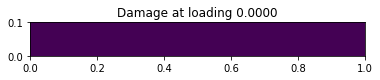

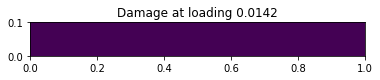

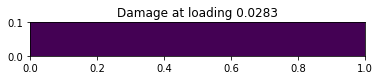

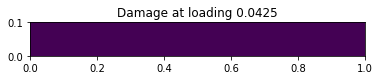

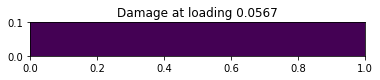

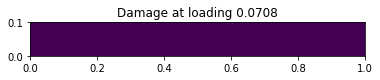

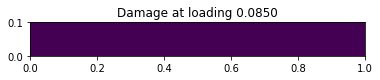

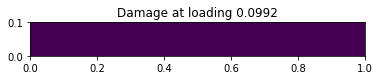

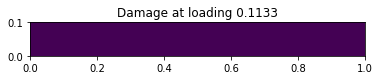

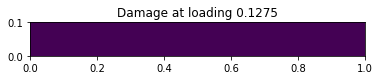

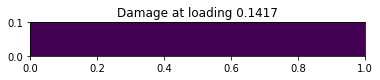

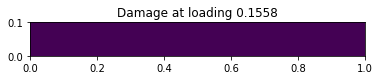

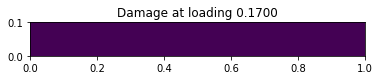

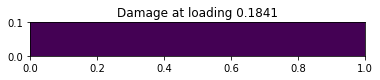

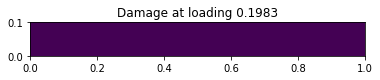

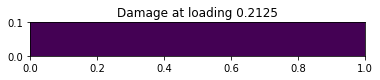

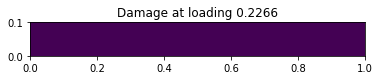

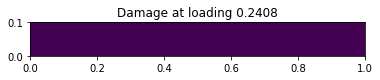

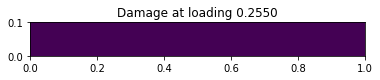

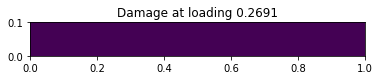

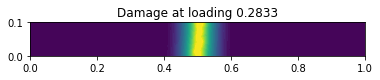

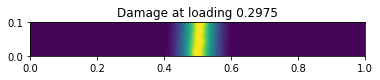

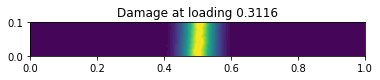

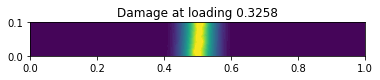

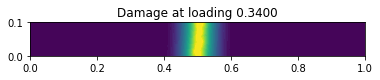

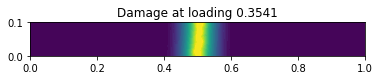

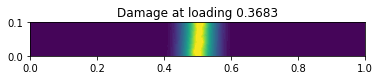

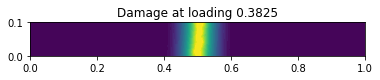

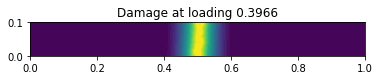

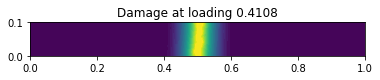

In [14]:
lb.interpolate(Constant(0.))
for (i_t, t) in enumerate(loads):
    u_R.t = t
    # solve alternate minimization
    alternate_minimization(u,alpha,maxiter=30)
    # updating the lower bound to account for the irreversibility
    lb.vector()[:] = alpha.vector()
    postprocessing()


# Postprocessing (skip)
We show the final deformed configuration and damage field

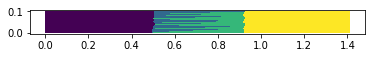

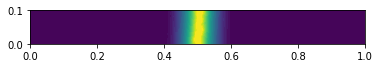

In [15]:
plt.figure(0)
plot(u,mode='displacement')
plt.figure(1)
plot(alpha)

Hence we plot the energy and the traction force as a function of the loading

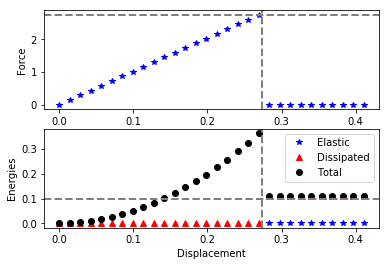

In [16]:
def critical_stress():
    xs = sympy.Symbol('x')
    wx = w(xs); sx = 1/(E*H*a(xs));
    res = sympy.sqrt(2*(Gc*H/c_w)*wx.diff(xs)/(sx.diff(xs)*ell))
    return res.evalf(subs={xs:0})

def plot_stress():
    plt.plot(forces[:,0], forces[:,1], 'b*', linewidth = 2)
    plt.xlabel('Displacement')
    plt.ylabel('Force')
    force_cr = critical_stress()
    plt.axvline(x = force_cr/(E*H)*L, color = 'grey', linestyle = '--', linewidth = 2)
    plt.axhline(y = force_cr, color = 'grey', linestyle = '--', linewidth = 2)

def plot_energy():
    p1, = plt.plot(energies[:,0], energies[:,1],'b*',linewidth=2)
    p2, = plt.plot(energies[:,0], energies[:,2],'r^',linewidth=2)
    p3, = plt.plot(energies[:,0], energies[:,3],'ko',linewidth=2)
    plt.legend([p1, p2, p3], ["Elastic","Dissipated","Total"])
    plt.xlabel('Displacement')
    plt.ylabel('Energies')
    force_cr = critical_stress()
    plt.axvline(x = force_cr/(E*H)*L, color = 'grey',linestyle = '--', linewidth = 2)
    plt.axhline(y = H,color = 'grey', linestyle = '--', linewidth = 2)

def plot_energy_stress():
    plt.subplot(211)
    plot_stress()
    plt.subplot(212)
    plot_energy()
    plt.savefig(savedir+'/energies_force.png')
    plt.show()

plot_energy_stress()

# Verification

The plots above indicates that the crack appear at the elastic limit calculated analytically (see the gridlines) and that the dissipated energy coincide with the length of the crack times $G_c$. Let's check the latter explicity

In [17]:
print("The dissipated energy on a crack is %.3f"%assemble(dissipated_energy))
print("The expeceted value is %f"%H)

The dissipated energy on a crack is 0.109
The expeceted value is 0.100000


Let us look at the damage profile

The expected half-width of the damage localisation is 0.10


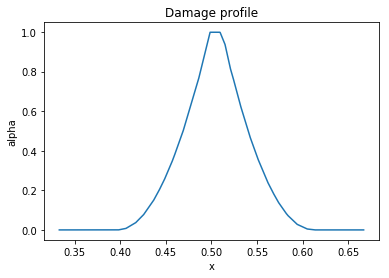

In [23]:
xs = np.linspace(L/3,2*L/3,1000)
plt.plot(xs,[alpha(x,H/2.) for x in xs], '-', label="damage profile")
plt.xlabel("x")
plt.ylabel("alpha")
plt.title("Damage profile")
print("The expected half-width of the damage localisation is %.2f"%float(c_1w*ell))

We can see that the over-dissipation in the finite element approcimation is due to the central element with unit damage, which should be a single point in the inifinite dimensional model. The error can be estimated as $G_c/c_w \ell*H*h$, where $h$ is the mesh size. Let's check this estimation

In [19]:
Gcerr = float(Gc/c_w/ell)*mesh.hmax()*H
print(Gcerr)

0.013564007074149328


This give a better agreement with the analytical result for infinite dimensional model. A numerical trick is to incorporate this error using a corrected value of the fracture toughness to use in the numerical simulations:
$$
    G_c^\mathrm{num}=\frac{G_c}{\left(1+\frac{h}{\ell}c_w\right)}
$$

In [20]:
print("The corrected value of the dissipated energy in the discrete model is %f"% float(Gcerr+Gc*H))
print("The dissipated energy on a crack is %.3f"%assemble(dissipated_energy))

The corrected value of the dissipated energy in the discrete model is 0.113564
The dissipated energy on a crack is 0.109
